# Synthetic Data Generation Using RAGAS - RAG Evaluation with LangSmith

In the following notebook we'll explore a use-case for RAGAS' synthetic testset generation workflow!



- 🤝 BREAKOUT ROOM #1
  1. Use RAGAS to Generate Synthetic Data

- 🤝 BREAKOUT ROOM #2
  1. Load them into a LangSmith Dataset
  2. Evaluate our RAG chain against the synthetic test data
  3. Make changes to our pipeline
  4. Evaluate the modified pipeline

SDG is a critical piece of the puzzle, especially for early iteration! Without it, it would not be nearly as easy to get high quality early signal for our application's performance.

Let's dive in!

# 🤝 BREAKOUT ROOM #1

## Task 1: Dependencies and API Keys

We'll need to install a number of API keys and dependencies, since we'll be leveraging a number of great technologies for this pipeline!

1. OpenAI's endpoints to handle the Synthetic Data Generation
2. OpenAI's Endpoints for our RAG pipeline and LangSmith evaluation
3. QDrant as our vectorstore
4. LangSmith for our evaluation coordinator!

Let's install and provide all the required information below!

## Dependencies and API Keys:

> NOTE: DO NOT RUN THESE CELLS IF YOU ARE RUNNING THIS NOTEBOOK LOCALLY

In [1]:
!pip install -qU ragas==0.2.10

In [2]:
!pip install -qU langchain-community==0.3.14 langchain-openai==0.2.14 unstructured==0.16.12 langgraph==0.2.61 langchain-qdrant==0.2.0

In [3]:
import os
import getpass

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

LangChain API Key:··········


We'll also want to set a project name to make things easier for ourselves.

In [4]:
from uuid import uuid4

os.environ["LANGCHAIN_PROJECT"] = f"AIM - SDG - {uuid4().hex[0:8]}"

OpenAI's API Key!

In [5]:
os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")

OpenAI API Key:··········


## Generating Synthetic Test Data

We wil be using Ragas to build out a set of synthetic test questions, references, and reference contexts. This is useful because it will allow us to find out how our system is performing.

> NOTE: Ragas is best suited for finding *directional* changes in your LLM-based systems. The absolute scores aren't comparable in a vacuum.

### Data Preparation

We'll prepare our data - and download our webpages which we'll be using for our data today.

These webpages are from [Simon Willison's](https://simonwillison.net/) yearly "AI learnings".

- [2023 Blog](https://simonwillison.net/2023/Dec/31/ai-in-2023/)
- [2024 Blog](https://simonwillison.net/2024/Dec/31/llms-in-2024/)

Let's start by collecting our data into a useful pile!

In [6]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [7]:
!curl https://simonwillison.net/2023/Dec/31/ai-in-2023/ -o data/2023_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 31314    0 31314    0     0  66101      0 --:--:-- --:--:-- --:--:-- 66063


In [8]:
!curl https://simonwillison.net/2024/Dec/31/llms-in-2024/ -o data/2024_llms.html

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 70173    0 70173    0     0   541k      0 --:--:-- --:--:-- --:--:--  543k


Next, let's load our data into a familiar LangChain format using the `DirectoryLoader`.

In [9]:
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

### Knowledge Graph Based Synthetic Generation

Ragas uses a knowledge graph based approach to create data. This is extremely useful as it allows us to create complex queries rather simply. The additional testset complexity allows us to evaluate larger problems more effectively, as systems tend to be very strong on simple evaluation tasks.

Let's start by defining our `generator_llm` (which will generate our questions, summaries, and more), and our `generator_embeddings` which will be useful in building our graph.

### Unrolled SDG

In [10]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

Next, we're going to instantiate our Knowledge Graph.

This graph will contain N number of nodes that have M number of relationships. These nodes and relationships (AKA "edges") will define our knowledge graph and be used later to construct relevant questions and responses.

In [11]:
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()
kg

KnowledgeGraph(nodes: 0, relationships: 0)

The first step we're going to take is to simply insert each of our full documents into the graph. This will provide a base that we can apply transformations to.

In [12]:
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )
kg

KnowledgeGraph(nodes: 2, relationships: 0)

Now, we'll apply the *default* transformations to our knowledge graph. This will take the nodes currently on the graph and transform them based on a set of [default transformations](https://docs.ragas.io/en/latest/references/transforms/#ragas.testset.transforms.default_transforms).

These default transformations are dependent on the corpus length, in our case:

- Producing Summaries -> produces summaries of the documents
- Extracting Headlines -> finding the overall headline for the document
- Theme Extractor -> extracts broad themes about the documents

It then uses cosine-similarity and heuristics between the embeddings of the above transformations to construct relationships between the nodes.

In [13]:
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)
kg

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

KnowledgeGraph(nodes: 14, relationships: 70)

We can save and load our knowledge graphs as follows.

In [14]:
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")
ai_across_years_kg

KnowledgeGraph(nodes: 14, relationships: 70)

Using our knowledge graph, we can construct a "test set generator" - which will allow us to create queries.

In [15]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

However, we'd like to be able to define the kinds of queries we're generating - which is made simple by Ragas having pre-created a number of different "QuerySynthesizer"s.

Each of these Synthetsizers is going to tackle a separate kind of query which will be generated from a scenario and a persona.

In essence, Ragas will use an LLM to generate a persona of someone who would interact with the data - and then use a scenario to construct a question from that data and persona.

In [16]:
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

#### ❓ Question #1:

What are the three types of query synthesizers doing? Describe each one in simple terms.


### Q1 ANSWER
 **SingleHopSpecificQuerySynthesizer**  
 This synthesizer generates simple, straightforward questions that can be answered with a single piece of information from one document.  
 ****
 **MultiHopAbstractQuerySynthesizer**  
 This synthesizer generates more abstract queries that are not directlr answerable by in the documents and inference may be needed. It creates more general, higher-level questions that require combining multiple pieces of information but remain somewhat broad or conceptual.
 ****
 **MultiHopSpecificQuerySynthesizer**  
 This synthesizer generates detailed, multi-step questions that require pulling information from different parts to answer.
 ****

Finally, we can use our `TestSetGenerator` to generate our testset!

In [17]:
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/11 [00:00<?, ?it/s]

,user_input,reference_contexts,reference,synthesizer_name
0,What Anthropic do with LLMs?,[Code may be the best application The ethics o...,Anthropic has produced better-than-GPT-3 class...,single_hop_specifc_query_synthesizer
1,What role does Python play in the context of L...,[Based Development As a computer scientist and...,"Python, as a programming language, benefits fr...",single_hop_specifc_query_synthesizer
2,Wht are the key developments in Artifical Inte...,[Simon Willison’s Weblog Subscribe Stuff we fi...,2023 was the breakthrough year for Large Langu...,single_hop_specifc_query_synthesizer
3,What insights can be drawn from the Plausible ...,[easy to follow. The rest of the document incl...,The Plausible analytics data reveals that AI-r...,single_hop_specifc_query_synthesizer
4,Wht are the new capabilities introdused by Goo...,[Prompt driven app generation is a commodity a...,"Google's Gemini 1.5 Pro, released in February ...",single_hop_specifc_query_synthesizer
5,How do the challenges of understanding and con...,[<1-hop>\n\nCode may be the best application T...,The challenges of understanding and controllin...,multi_hop_abstract_query_synthesizer
6,How does OpenAI's approach to AI ethics and le...,[<1-hop>\n\nCode may be the best application T...,OpenAI's approach to AI ethics and legality si...,multi_hop_abstract_query_synthesizer
7,How do the challenges of understanding and con...,[<1-hop>\n\nCode may be the best application T...,The challenges of understanding and controllin...,multi_hop_abstract_query_synthesizer
8,What advancements in GPT-4o highlight its capa...,[<1-hop>\n\nAnother common technique is to use...,GPT-4o represents an advancement over earlier ...,multi_hop_specific_query_synthesizer
9,How did the release of Claude 3.5 Sonnet and i...,[<1-hop>\n\nfeed with the model and talk about...,The release of Claude 3.5 Sonnet by Anthropic ...,multi_hop_specific_query_synthesizer


In [18]:
questions = testset.to_pandas()
questions['reference'].iloc[0]

'Anthropic has produced better-than-GPT-3 class models, contributing to the advancements in Large Language Models.'

### Abstracted SDG

The above method is the full process - but we can shortcut that using the provided abstractions!

This will generate our knowledge graph under the hood, and will - from there - generate our personas and scenarios to construct our queries.



In [19]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)

Applying HeadlinesExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying HeadlineSplitter:   0%|          | 0/2 [00:00<?, ?it/s]

Applying SummaryExtractor:   0%|          | 0/2 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/12 [00:00<?, ?it/s]

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/26 [00:00<?, ?it/s]

Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/2 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

### NOTE:
Here we didn't pass the custom query_distribution and that's why generated questions are in a default distribution equal number of queries for each type.
    
WHY testset_size=10 but the resulted testset size is 12?

In [20]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,How has Google contributed to the advancements...,[Code may be the best application The ethics o...,Google is among the organizations that have pr...,single_hop_specifc_query_synthesizer
1,How LLMs handle Spanish grammar compared to pr...,[Based Development As a computer scientist and...,The grammar rules of programming languages lik...,single_hop_specifc_query_synthesizer
2,Who is Simon Willison in the context of AI adv...,[Simon Willison’s Weblog Subscribe Stuff we fi...,Simon Willison is the author of a weblog that ...,single_hop_specifc_query_synthesizer
3,How has the concept of 'Stable Diffusion' been...,[easy to follow. The rest of the document incl...,The context mentions that large language model...,single_hop_specifc_query_synthesizer
4,How does the black box nature of AI impact the...,[<1-hop>\n\nCode may be the best application T...,The black box nature of AI significantly impac...,multi_hop_abstract_query_synthesizer
5,How have advancements in large language models...,[<1-hop>\n\nCode may be the best application T...,Advancements in large language models have sig...,multi_hop_abstract_query_synthesizer
6,How have advancements in large language models...,[<1-hop>\n\nCode may be the best application T...,Advancements in large language models have sig...,multi_hop_abstract_query_synthesizer
7,How do the advancements in Large Language Mode...,[<1-hop>\n\nCode may be the best application T...,The advancements in Large Language Models (LLM...,multi_hop_abstract_query_synthesizer
8,How have recent advancements in large language...,[<1-hop>\n\nfeed with the model and talk about...,"Recent advancements in large language models, ...",multi_hop_specific_query_synthesizer
9,How has the efficiency and cost-effectiveness ...,[<1-hop>\n\nAnother common technique is to use...,The efficiency and cost-effectiveness of GPT-4...,multi_hop_specific_query_synthesizer


We'll need to provide our LangSmith API key, and set tracing to "true".

In [21]:
dataset.to_pandas().to_csv('ragas_data.csv')


# 🤝 BREAKOUT ROOM #2

## Task 4: LangSmith Dataset

Now we can move on to creating a dataset for LangSmith!

First, we'll need to create a dataset on LangSmith using the `Client`!

We'll name our Dataset to make it easy to work with later.

In [23]:
from langsmith import Client

client = Client()


dataset_name = "State of AI Across the Years - v2"

langsmith_dataset = client.create_dataset(
    dataset_name=dataset_name,
    description="State of AI Across the Years v2"
)

We'll iterate through the RAGAS created dataframe - and add each example to our created dataset!

> NOTE: We need to conform the outputs to the expected format - which in this case is: `question` and `answer`.

In [24]:
dataset.to_pandas()

,user_input,reference_contexts,reference,synthesizer_name
0,How has Google contributed to the advancements...,[Code may be the best application The ethics o...,Google is among the organizations that have pr...,single_hop_specifc_query_synthesizer
1,How LLMs handle Spanish grammar compared to pr...,[Based Development As a computer scientist and...,The grammar rules of programming languages lik...,single_hop_specifc_query_synthesizer
2,Who is Simon Willison in the context of AI adv...,[Simon Willison’s Weblog Subscribe Stuff we fi...,Simon Willison is the author of a weblog that ...,single_hop_specifc_query_synthesizer
3,How has the concept of 'Stable Diffusion' been...,[easy to follow. The rest of the document incl...,The context mentions that large language model...,single_hop_specifc_query_synthesizer
4,How does the black box nature of AI impact the...,[<1-hop>\n\nCode may be the best application T...,The black box nature of AI significantly impac...,multi_hop_abstract_query_synthesizer
5,How have advancements in large language models...,[<1-hop>\n\nCode may be the best application T...,Advancements in large language models have sig...,multi_hop_abstract_query_synthesizer
6,How have advancements in large language models...,[<1-hop>\n\nCode may be the best application T...,Advancements in large language models have sig...,multi_hop_abstract_query_synthesizer
7,How do the advancements in Large Language Mode...,[<1-hop>\n\nCode may be the best application T...,The advancements in Large Language Models (LLM...,multi_hop_abstract_query_synthesizer
8,How have recent advancements in large language...,[<1-hop>\n\nfeed with the model and talk about...,"Recent advancements in large language models, ...",multi_hop_specific_query_synthesizer
9,How has the efficiency and cost-effectiveness ...,[<1-hop>\n\nAnother common technique is to use...,The efficiency and cost-effectiveness of GPT-4...,multi_hop_specific_query_synthesizer


In [25]:
for data_row in dataset.to_pandas().iterrows():
  client.create_example(
      inputs={
          "question": data_row[1]["user_input"]
      },
      outputs={
          "answer": data_row[1]["reference"]
      },
      metadata={
          "context": data_row[1]["reference_contexts"]
      },
      dataset_id=langsmith_dataset.id
  )

## Basic RAG Chain

Time for some RAG!


In [26]:
rag_documents = docs

To keep things simple, we'll just use LangChain's recursive character text splitter!


In [27]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 500,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

We'll create our vectorstore using OpenAI's [`text-embedding-3-small`](https://platform.openai.com/docs/guides/embeddings/embedding-models) embedding model.

In [28]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

As usual, we will power our RAG application with Qdrant!

In [29]:
from langchain_community.vectorstores import Qdrant

vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="State of AI"
)

In [30]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 10})

To get the "A" in RAG, we'll provide a prompt.

In [31]:
from langchain.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

Context: {context}
Question: {question}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_PROMPT)

For our LLM, we will be using TogetherAI's endpoints as well!

We're going to be using Meta Llama 3.1 70B Instruct Turbo - a powerful model which should get us powerful results!

In [32]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

Finally, we can set-up our RAG LCEL chain!

In [33]:
from operator import itemgetter
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from langchain.schema import StrOutputParser

rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | rag_prompt | llm | StrOutputParser()
)

In [34]:
rag_chain.invoke({"question" : "What are Agents?"})

'Agents are a vague term in the context of AI that generally refers to AI systems designed to act on behalf of users. There are two main interpretations: one sees agents as entities that perform tasks for users, similar to a travel agent, while another views them as large language models (LLMs) with access to tools that can solve problems iteratively. However, the term lacks a clear and widely accepted definition, and many discussions about agents highlight challenges such as gullibility and the need for autonomy in their functioning.'

## LangSmith Evaluation Set-up

We'll use OpenAI's GPT-4o as our evaluation LLM for our base Evaluators.

In [35]:
eval_llm = ChatOpenAI(model="gpt-4o")

We'll be using a number of evaluators - from LangSmith provided evaluators, to a few custom evaluators!

In [36]:
from langsmith.evaluation import LangChainStringEvaluator, evaluate

qa_evaluator = LangChainStringEvaluator("qa", config={"llm" : eval_llm})

labeled_helpfulness_evaluator = LangChainStringEvaluator(
    "labeled_criteria",
    config={
        "criteria": {
            "helpfulness": (
                "Is this submission helpful to the user,"
                " taking into account the correct reference answer?"
            )
        },
        "llm" : eval_llm
    },
    prepare_data=lambda run, example: {
        "prediction": run.outputs["output"],
        "reference": example.outputs["answer"],
        "input": example.inputs["question"],
    }
)

dope_or_nope_evaluator = LangChainStringEvaluator(
    "criteria",
    config={
        "criteria": {
            "dopeness": "Is this submission dope, lit, or cool?",
        },
        "llm" : eval_llm
    }
)

#### 🏗️ Activity #2:

Highlight what each evaluator is evaluating.

- `qa_evaluator`:
- `labeled_helpfulness_evaluator`:
- `dope_or_nope_evaluator`:

### ANSWER
****
**qa_evaluator :**  
Measures correctness which determines whether an LLM output is factually correct based on some ground truth  
****
**labeled_helpfulness_evaluator :**  
The "labeled_criteria" evaluator instructs an LLM to assess if a prediction satisfies the criteria, taking into account the reference label. Criteria here is "helfulness" so the LLM assess if the prediction is helpful to the user  
****
**dope_or_nope_evaluator :**  
The "criteria" evaluator instructs an LLM to assess if a prediction satisfies the given criteria, without taking reference label into account. Here we instruct the LLM to label the prediction as "dope", "lit" or "cool"  
****

## LangSmith Evaluation

In [38]:
evaluate(
    rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "default_chain_init"},
)

View the evaluation results for experiment: 'slight-church-6' at:
https://smith.langchain.com/o/73a1f3ba-0d4a-4422-a192-2262a2ce081d/datasets/12ed9c68-4f41-42c7-97ad-e3ed5abe7260/compare?selectedSessions=cb7dabfd-39f5-486d-8898-923a0d5cd312




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,What are some recent advancements in ChatGPT a...,Recent advancements in ChatGPT include the int...,None,Recent advancements in ChatGPT include the int...,0,0,1,3.612872,2c558d15-6a29-4092-b75d-b1ad52b4fca7,70f7a918-8ba4-4ac6-95ec-c2535e0b641d
1,How do the challenges of evaluating LLMs and t...,The challenges of evaluating LLMs stem from th...,None,"The challenges of evaluating LLMs, such as the...",1,0,0,2.624574,20ade0ad-e4ef-49d7-801b-cbfce5725a7f,6b1bdfa2-2a73-4a40-ae9c-af20a11604ec
2,How has the efficiency and cost-effectiveness ...,I don't know.,None,The efficiency and cost-effectiveness of GPT-4...,0,0,0,1.122122,6d6bda8c-8aeb-4aea-a2fc-9fc79f27bd1f,c49787ac-8c54-4280-800f-0c453f1eb68f
3,How have recent advancements in large language...,Recent advancements in large language models (...,None,"Recent advancements in large language models, ...",1,0,0,2.264546,e9f33c41-159a-4da2-9b2e-2ba40e311d65,9684ebb9-23bd-4d07-be74-ecc0af4ca526
4,How do the advancements in Large Language Mode...,I don't know.,None,The advancements in Large Language Models (LLM...,0,0,0,0.972313,28d1aba4-d38b-45cb-84de-27b866130da7,e1ca3fa4-d9c6-4931-8347-e795672488ad
5,How have advancements in large language models...,Advancements in large language models have led...,None,Advancements in large language models have sig...,1,0,0,3.671057,43d0efb4-a341-466a-abb7-a39394b40613,c88b920e-3fa6-484b-a976-2df164889560
6,How have advancements in large language models...,Advancements in large language models (LLMs) h...,None,Advancements in large language models have sig...,0,0,0,3.282332,44d6e7e9-5a9d-4978-bf49-d2af0aa6f67c,997e5e05-1fda-43a7-827d-ccb0ffa99939
7,How does the black box nature of AI impact the...,The black box nature of AI significantly impac...,None,The black box nature of AI significantly impac...,1,1,0,4.138883,2de64fe9-7291-4cc5-9d53-2fdf31c4ae23,15f8dfa3-1f56-4a2f-a313-7dbbbe189d37
8,How has the concept of 'Stable Diffusion' been...,The concept of 'Stable Diffusion' has been dis...,None,The context mentions that large language model...,0,0,1,5.871525,8d7e8114-eec4-4846-a6b5-64c52cd80d64,f91e6d88-8042-4f28-9640-709d006d3eac
9,Who is Simon Willison in the context of AI adv...,Simon Willison is a blogger who has documented...,None,Simon Willison is the author of a weblog that ...,1,1,0,1.667255,90b676ca-34d9-4d0b-9421-81542ebf0935,a6d6de79-fe28-4984-b5f5-9250d77969d8


## Dope-ifying Our Application

We'll be making a few changes to our RAG chain to increase its performance on our SDG evaluation test dataset!

- Include a "dope" prompt augmentation
- Use larger chunks
- Improve the retriever model to: `text-embedding-3-large`

Let's see how this changes our evaluation!

In [37]:
DOPE_RAG_PROMPT = """\
Given a provided context and question, you must answer the question based only on context.

If you cannot answer the question based on the context - you must say "I don't know".

You must answer the questions in a dope way, be cool!

Context: {context}
Question: {question}
"""

dope_rag_prompt = ChatPromptTemplate.from_template(DOPE_RAG_PROMPT)

In [39]:
rag_documents = docs

In [40]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 1000,
    chunk_overlap = 50
)

rag_documents = text_splitter.split_documents(rag_documents)

#### ❓Question #2:

Why would modifying our chunk size modify the performance of our application?

### Q2 ANSWER
Increasing the chunk size means giving more context to the LLM so this might improve its performance

In [ ]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

#### ❓Question #3:

Why would modifying our embedding model modify the performance of our application?

### Q3 ANSWER
Using a better embedder that's used in embedding the chunks and the query means that we get better embeddings and representation of them resulting in improving the retrieval process. More relevant chunks will be retrieved and giving to the LLM so the LLM will perform better.

In [41]:
vectorstore = Qdrant.from_documents(
    documents=rag_documents,
    embedding=embeddings,
    location=":memory:",
    collection_name="AI Across Years (Augmented)"
)

In [42]:
retriever = vectorstore.as_retriever()

Setting up our new and improved DOPE RAG CHAIN.

In [43]:
dope_rag_chain = (
    {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
    | dope_rag_prompt | llm | StrOutputParser()
)

Let's test it on the same output that we saw before.

In [44]:
dope_rag_chain.invoke({"question" : "what are Agents?"})

"Agents, my friend, are like those mysterious figures in the AI world that are supposed to act on your behalf, but the term is a total enigma! Some envision them as digital travel agents, while others think of LLMs using tools in a problem-solving loop. The catch? Everyone's got a different definition, and it’s super vague. Right now, they’re still in that “coming soon” phase, battling issues like gullibility, which makes it tough for them to be reliable. So, until we crack the code on what they really are, it’s all just smoke and mirrors!"

Finally, we can evaluate the new chain on the same test set!

In [45]:
evaluate(
    dope_rag_chain.invoke,
    data=dataset_name,
    evaluators=[
        qa_evaluator,
        labeled_helpfulness_evaluator,
        dope_or_nope_evaluator
    ],
    metadata={"revision_id": "dope_chain"},
)

View the evaluation results for experiment: 'perfect-silk-11' at:
https://smith.langchain.com/o/73a1f3ba-0d4a-4422-a192-2262a2ce081d/datasets/12ed9c68-4f41-42c7-97ad-e3ed5abe7260/compare?selectedSessions=54cd6f87-e8f2-4b05-a20b-9e03d9b9efdf




0it [00:00, ?it/s]

,inputs.question,outputs.output,error,reference.answer,feedback.correctness,feedback.helpfulness,feedback.dopeness,execution_time,example_id,id
0,What are some recent advancements in ChatGPT a...,"Yo, check it out! Recent advancements in ChatG...",None,Recent advancements in ChatGPT include the int...,0,0,1,6.230385,2c558d15-6a29-4092-b75d-b1ad52b4fca7,ad78f8bb-3563-4b5a-bb4c-e17fd48c51f0
1,How do the challenges of evaluating LLMs and t...,"Man, the challenges of evaluating LLMs are rea...",None,"The challenges of evaluating LLMs, such as the...",1,0,1,2.831026,20ade0ad-e4ef-49d7-801b-cbfce5725a7f,d8204eb0-2571-4b1b-9c00-7f35556a5da8
2,How has the efficiency and cost-effectiveness ...,"Yo, check it! The efficiency and cost-effectiv...",None,The efficiency and cost-effectiveness of GPT-4...,1,0,1,4.195258,6d6bda8c-8aeb-4aea-a2fc-9fc79f27bd1f,1fedbb9d-475d-46f3-96c6-f9e912f84d91
3,How have recent advancements in large language...,"Yo, it’s a wild ride in the world of large lan...",None,"Recent advancements in large language models, ...",1,0,1,5.827522,e9f33c41-159a-4da2-9b2e-2ba40e311d65,e6399103-0025-4ebc-8714-e1fc4c673478
4,How do the advancements in Large Language Mode...,"Yo, check it! The advancements in LLMs showcas...",None,The advancements in Large Language Models (LLM...,1,0,1,3.736157,28d1aba4-d38b-45cb-84de-27b866130da7,d05e9443-a9bb-474a-8bfd-0cddbf97bddd
5,How have advancements in large language models...,"Yo, let me break it down for you! Advancements...",None,Advancements in large language models have sig...,0,0,1,4.101567,43d0efb4-a341-466a-abb7-a39394b40613,d28b7f3d-b376-4d0a-8b86-9ac97b735ab6
6,How have advancements in large language models...,"Yo, check it out! Advancements in large langua...",None,Advancements in large language models have sig...,0,0,1,2.938970,44d6e7e9-5a9d-4978-bf49-d2af0aa6f67c,59acd5d3-22b9-45ba-ae01-7c2f83f974c7
7,How does the black box nature of AI impact the...,"Yo, the black box nature of AI is like trying ...",None,The black box nature of AI significantly impac...,1,0,1,2.303828,2de64fe9-7291-4cc5-9d53-2fdf31c4ae23,8f3ee871-1317-4ad4-8746-d1d8099571ef
8,How has the concept of 'Stable Diffusion' been...,"Yo, so the whole ""Stable Diffusion"" vibe got b...",None,The context mentions that large language model...,0,0,1,3.149164,8d7e8114-eec4-4846-a6b5-64c52cd80d64,26f8f3ac-fed8-4e5e-b9f2-78070238d9b3
9,Who is Simon Willison in the context of AI adv...,Simon Willison is a dude who's diving deep int...,None,Simon Willison is the author of a weblog that ...,1,1,1,2.339077,90b676ca-34d9-4d0b-9421-81542ebf0935,af829190-22a6-4f70-a941-918c08970e0e


#### 🏗️ Activity #3:

Provide a screenshot of the difference between the two chains, and explain why you believe certain metrics changed in certain ways.

### ANSWER
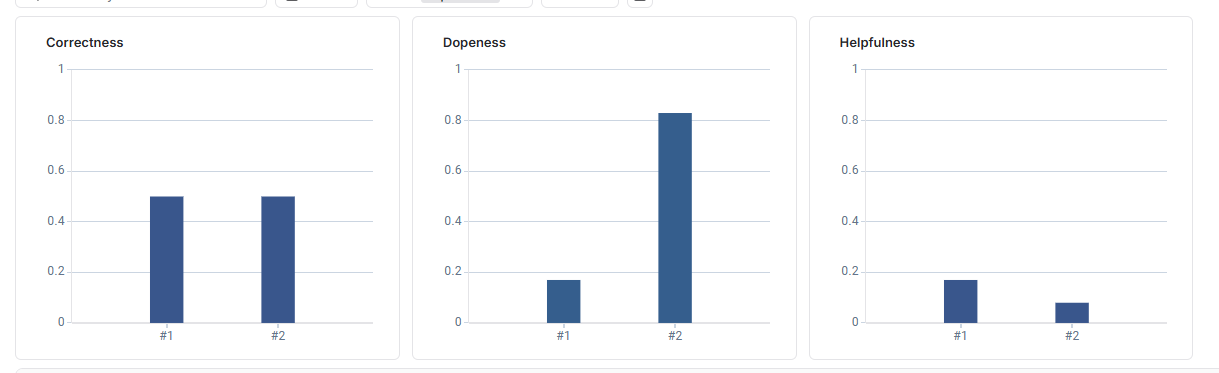

So this was unexpected.

**Dopeness** increased significantly meaning that LLM followed the new instruction of making the answer dope and it suceeded in that.  

**Correctness** didn't change. This may indicate that chaging the embedder and increasing the chunk size didn't make that much of a difference. Or maybe it got better answers but making them dope affected those answers.


**Helpfulness** is worse. I believe that's because LLM kept changing the correct answer to make it dope and these changes affected the context of the answer making it less understandable and less helpful


Correct, Not Dope, Helpful  
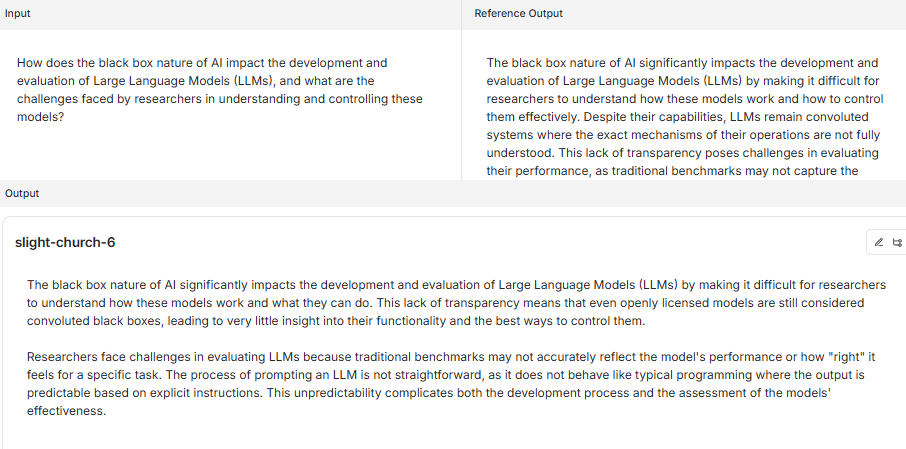  

Correct, Dope, Not Helpful  
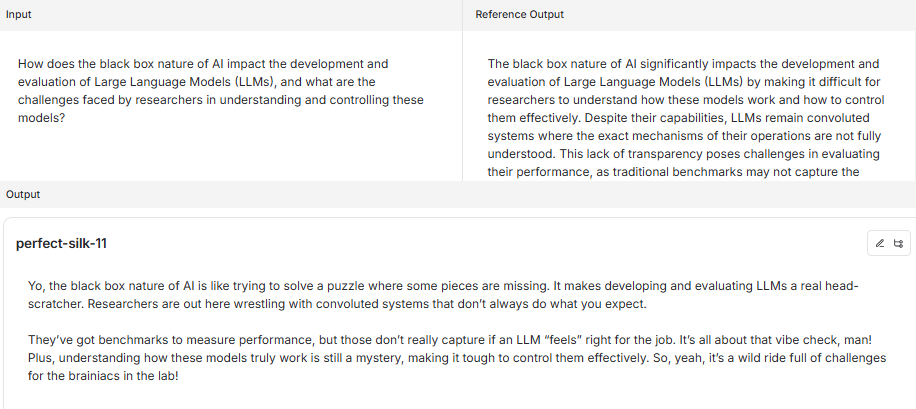

# Full Code




In [ ]:
#######################3 Use RAGAS for SDG

# Load data in a langchain format
from langchain_community.document_loaders import DirectoryLoader

path = "data/"
loader = DirectoryLoader(path, glob="*.html")
docs = loader.load()

# Load LLM that will generate data and embedder
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings
generator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o"))
generator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

# Initialze Knowledge Graph
from ragas.testset.graph import KnowledgeGraph

kg = KnowledgeGraph()

# Add 2 nodes 1 node per document
from ragas.testset.graph import Node, NodeType

for doc in docs:
    kg.nodes.append(
        Node(
            type=NodeType.DOCUMENT,
            properties={"page_content": doc.page_content, "document_metadata": doc.metadata}
        )
    )

# Apply transformations on node like (summaries, headlines, themes) to make subnodes and edges
from ragas.testset.transforms import default_transforms, apply_transforms

transformer_llm = generator_llm
embedding_model = generator_embeddings

default_transforms = default_transforms(documents=docs, llm=transformer_llm, embedding_model=embedding_model)
apply_transforms(kg, default_transforms)

# Save and load Knowledge graph as json
kg.save("ai_across_years_kg.json")
ai_across_years_kg = KnowledgeGraph.load("ai_across_years_kg.json")

# Define the data generator
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=embedding_model, knowledge_graph=ai_across_years_kg)

# Specify percentages of test set among different type of queries
from ragas.testset.synthesizers import default_query_distribution, SingleHopSpecificQuerySynthesizer, MultiHopAbstractQuerySynthesizer, MultiHopSpecificQuerySynthesizer

query_distribution = [
        (SingleHopSpecificQuerySynthesizer(llm=generator_llm), 0.5),
        (MultiHopAbstractQuerySynthesizer(llm=generator_llm), 0.25),
        (MultiHopSpecificQuerySynthesizer(llm=generator_llm), 0.25),
]

# Generate Questions
testset = generator.generate(testset_size=10, query_distribution=query_distribution)
testset.to_pandas()

# Another shorter code to generate questions (docs --> questions)
from ragas.testset import TestsetGenerator

generator = TestsetGenerator(llm=generator_llm, embedding_model=generator_embeddings)
dataset = generator.generate_with_langchain_docs(docs, testset_size=10)